#### 1. Keras로 MF 구현하기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [2]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]


- Variable 초기화

In [3]:
K= 200                                # (잠재요인)Latent factor 수
mu = ratings_train.rating.mean()      # 전체평균
M = ratings.user_id.max() +1          # Number of users
N = ratings.movie_id.max() +1         # Number of movies
# 사용자 아이다와 영화 아이디의 최대값을 구한다. 나중에 embedding에 사용된다.

- RMSE 정의

In [4]:
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred))) # 여기서는 np.sqrt가 아님을 주의
# y_pred와 y_true는 신경망에서 예측값, 실제값을 나타내는 Tensorflow/Keras의 표준변수이다. 

- Keras model

In [5]:
user = Input(shape=(1,)) # 사용자 데이터 입력 형식을 지정한다.
item = Input(shape=(1,)) # 아이템 데이터 입력 형식을 지정한다.
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user) 
# 사용자 embedding layer 지정. 이미 설명한 것과 같이 (M x K)의 연결을 가진다.
Q_embedding = Embedding(N,K, embeddings_regularizer=l2())(item)
# 아이템 embedding layyer 지정. (N x K)의 연결을 가진다.
user_bias = Embedding(M,1, embeddings_regularizer=l2())(user)
# 사용자 bias embedding 지정. (M x 1)의 연결을 가진다.
item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)
# 아이템 bias embedding layer 지정. (N x 1)의 연결을 가진다.

이 코드에서 추가적인 설명인 필요한 부분은 RMSE() 함수이다. 지금까지 추천 시스템의 정확도지표로서 RMSE를 사용해 왔다.    
Keras에는 미리 정의된 RMSE 측정지표가 없기 때문에 RMSE 계산을 위한 함수를 새로 정의한 것이 코드에 있는 RMSE()이다.   
이 RMSE 함수는 지금까지 RMSE의 계산을 위해서 사용한 함수와 형태는 비슷하지만 구체적인 코드는 다르다. 
예를 들어 전에는 제곱근을 계산하기 위해서 np.sqrt()함수를 사용했는데 여기서는 Tensorflow의 함수인 tf.sqrt()를 사용한다.
그 이유는 Tensorflow/Keras에서 신경망과 관련된 값을 계산하기 위해서는 Tensorflow/Keras에 미리 정의된 함수와 클래스를 사용해야 하기 때문이다.

In [6]:
#R = Dot(axes=2)([P_embedding, Q_embedding)
R = layers.dot([P_embedding, Q_embedding], axes=2)                      # (1, 1, 1)
# 사용자, 아이템 embedding 레이어를 내적 연산(dot product)을 한다. 
# 같은 일을 하는 다른 코드로 R=Dot(axes=2)([P_embedding,Q_embedding])도 가능하다.
# R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
# 사용자 bias, 아이템 bias르 더한다. 다른 코드로 R = Add()([R,user_bias,item_bias])도 가능하다.
R = Flatten()(R)                                                        # (1, 1)
# 차원을 압축한다. 즉 1차원 형태의 배열로 변경한다.

In [7]:
model = Model(inputs=[user,item],outputs=R)
# 입력과 출력의 정의한다.

In [8]:
model.compile(
    # 모델 컴파일 조건을 지정한다.
    loss=RMSE,
    # loss 측정을 RMSE로 정의한다.
    optimizer=SGD(),
    # optimizer로 SGD를 사용한다. SGD의 다양한 파라미터를 () 안에 지정할 수도 있지만,
    # 여기서는 설명의 단순화를 위해 아무것도 지정하지 않고, 기본값을 사용하였다.
    # SGD 외에 사용할 수 있는 optimizer가 다수 있다. 예를 들어 Adamax를 사용한다면 
    # 이 코드를 optimizer=ADamax(),로 대체하면 된다. 
    metrics=[RMSE]
    # 측정지표를 RMSE로 사용한다.
)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
model.summary()
# 모델 요약 정보를 표시한다.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

이 표에서는 Layer의 이름, 데이터 형식, 파라미터 수, 해당 layer가 연결되어 있는 다른 layer 등을 보여준다.  
표를 보면 우선 embedding, embedding_1은(Layer이름 끝에 붙는 숫자는 실행할 때마다 다를 수 있음) 각각 사용자와 아이템의 잠재 요인,  
즉 P,Q를 나타낸다.현재 train set에서는 사용자가 944, 아이템이 1683이고 (M,N의 값에서 확인 가능) 각 사용자, 아이템에 대해서 K=200  
의  잠재요인), 즉 P,Q를 나타낸다. 현재 train set 에서는 사용자가 944, 아이템이 1683이고(M,N의 값에서 확인 가능) 각 사용자, 아이템
에 대해서 K=200의 잠재요인을 지정했기 때문에 총 연결(파라미터)은 사용자의 경우 944 X 200 = 188,800, 아이템의 경우 1,683 X 200 = 336,600이 된다. 또한 embedding_2와 embedding_3는 각각 사용자, 아이템 bias layer인데, 사용자와 아이템 하나에 대해서 1개씩의 연결이
생기기 때문에 각각 944, 1,683개의 연결(파라미터)이 만들어짐을 확인할 수 있다. 여기까지가 Keras 신경망을 구성하기 위한 코드였다.  
여기에 더해서 신경망 학습에 관련된 코드는 아래와 같다.

- 모델 fitting

In [9]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [10]:
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values],
    # train set의 입력을 지정하는 부분. 입력은 각 사용자와 아이템을 구분하기 위한 One-hot encoding을 위해서 각 사용자와
    # 아이템의 ID가 사용된다.
    y=ratings_train.rating.values - mu,
    # train set의 출력을 지정하는 부분, 출력은 평점값에서 전체평균을 빼서 샤용한다. 전체평균을 빼는 이유는 앞에서 설명함
    epochs=60,
    # 반복횟수를 지정한다.
    batch_size=256,
    # 한 번에 학습하는 batch 크기를 지정한다.
    validation_data=(
        # 정확도 측정을 위해 test 셋을 지정한다.
    [ratings_test.user_id.values,ratings_test.movie_id.values],
        # train set과 마찬가지로 test set의 입력은 test set의 사용자, 아이템 ID가 된다.
    ratings_test.rating.values - mu),
        # 출력 (y_valid로 보면 된다.)은 평점에서 전체평균을 뺀 값이 된다.
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/60
293/293 [==============================] - 2s 5ms/step - loss: 5.2810 - RMSE: 1.1245 - val_loss: 5.0429 - val_RMSE: 1.1261
Epoch 2/60
 35/293 [==>...........................] - ETA: 1s - loss: 5.0020 - RMSE: 1.1117

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


293/293 [==============================] - 1s 5ms/step - loss: 4.8192 - RMSE: 1.1224 - val_loss: 4.6078 - val_RMSE: 1.1241
Epoch 3/60
293/293 [==============================] - 1s 5ms/step - loss: 4.4085 - RMSE: 1.1206 - val_loss: 4.2209 - val_RMSE: 1.1224
Epoch 4/60
293/293 [==============================] - 1s 5ms/step - loss: 4.0434 - RMSE: 1.1188 - val_loss: 3.8768 - val_RMSE: 1.1207
Epoch 5/60
293/293 [==============================] - 1s 5ms/step - loss: 3.7186 - RMSE: 1.1172 - val_loss: 3.5708 - val_RMSE: 1.1192
Epoch 6/60
293/293 [==============================] - 1s 5ms/step - loss: 3.4298 - RMSE: 1.1157 - val_loss: 3.2987 - val_RMSE: 1.1178
Epoch 7/60
293/293 [==============================] - 1s 5ms/step - loss: 3.1729 - RMSE: 1.1143 - val_loss: 3.0567 - val_RMSE: 1.1165
Epoch 8/60
293/293 [==============================] - 1s 5ms/step - loss: 2.9444 - RMSE: 1.1129 - val_loss: 2.8415 - val_RMSE: 1.1152
Epoch 9/60
293/293 [==============================] - 1s 5ms/step - loss:

- epoch별 측정지표의 변화를 그래프로 표시하기 위한 것으로서 실행하면 다음과 같다

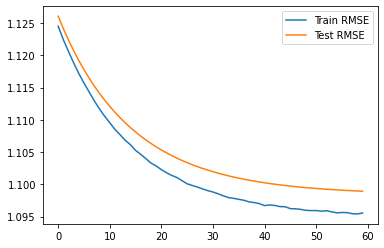

In [11]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'],label="Train RMSE")
plt.plot(result.history['val_RMSE'], label= "Test RMSE")
plt.legend()
plt.show()

학습을 마친 신경망을 예측에 사용하려면 아래와 같은 코드를 쓰면 된다.

In [12]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
# 예측 대상(사용자-아이템)을 train set의 맨 처음 6개로 정한다.
predictions = model.predict([user_ids,movie_ids])+mu
# 예측치를 구한 후 전체평균을 더한다.
print("Actuals : \n", ratings_test[0:6])
# 실제값과 예측값 출력
print()
print("Predictions: \n", predictions)

Actuals : 
        user_id  movie_id  rating
28750      250       270       4
65311      891       280       3
4190       235       898       3
93530      561       144       3
14071      130       800       4
65945      487       156       4

Predictions: 
 [[3.548358 ]
 [3.5293832]
 [3.5403934]
 [3.494641 ]
 [3.5758607]
 [3.5732164]]


신경망에서 예측한 결과의 실제 RMSE값을 계산해 보도록 한다. 앞에서 보았듯이 Keras는 신경망의 학습과정에서 test set에 대한 예측을  
하고 이 때의 RMSE값을 'val_RMSE'값을 출력해 준다. 학습이 끝난 최종 신경망을 사용해서 예측을 하고 이 예측값과 실제값의 차이를  
RMSE값으로 측정하는 코드가 아래에 있다.

In [13]:
def RMSE2(y_true,y_pred):
    return np.sqrt(np.mean((np.array(y_true)- np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids,movie_ids]) +mu
y_pred = np.ravel(y_pred,order='C')
y_true= np.array(ratings_test.rating)

In [14]:
RMSE2(y_true,y_pred)

1.0998959873681406

학습과정의 최종 epoch의 val_RMSE와 값이 거의 같음을 볼 수 있다. RMSE값이 앞의 제4장에서의 값보다 나쁜 것은  
MF와 Keras의 모델이 기본적인 것은 같지만 구체적인 부분에서 아직 최적화가 안되었기 때문이라고 할 수 있다.  
예를 들어서 SGD의 파라미터나 학습할 떄의 조건(epoch,batch size 등)이 다르기 때문이다.  

#### 2.딥러닝을 적용한 추천 시스템

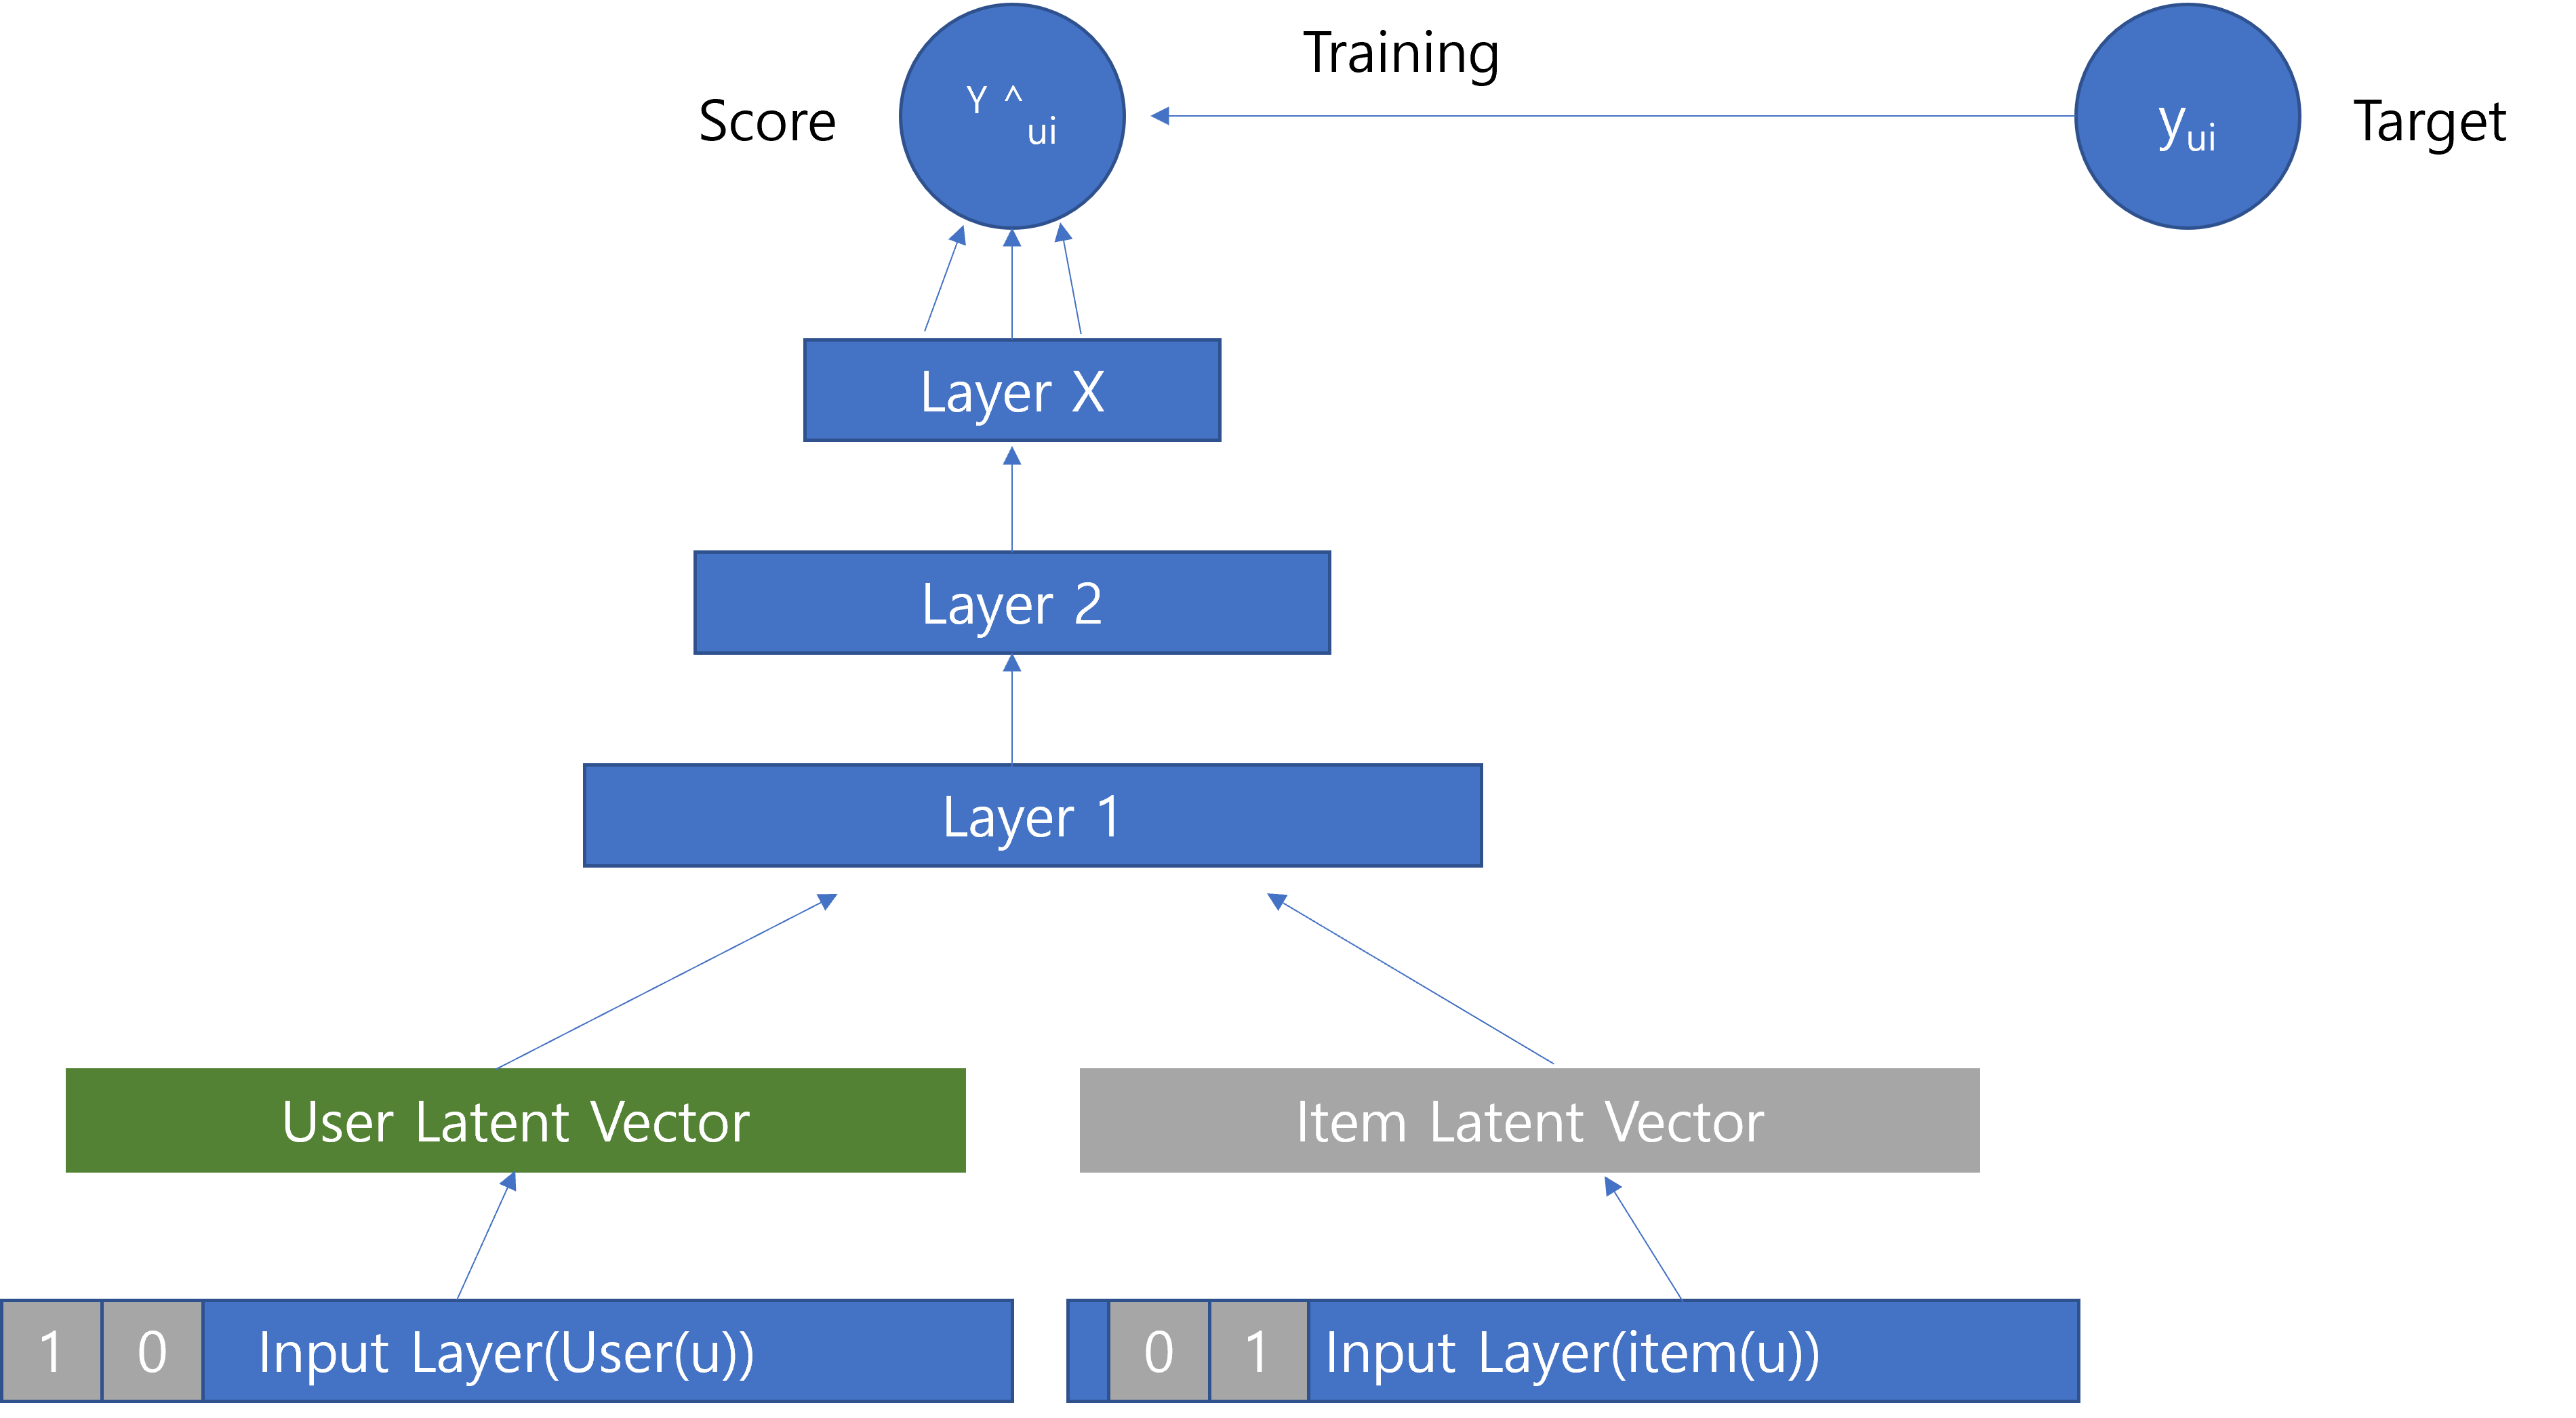

In [15]:
from IPython.display import Image
Image("C:/Users/USER/Downloads/데이터/추천시스템을 위한 딥러닝의 구조.png")

앞에서 선언한 MF모델은 은닉층이 없다. 그렇지만 일반적인 딥러닝은 은닉층이 다수 존재해서 다양한 패턴을 학습할 수 있는 것이 장점이기  
떄문에 딥러닝을 추천에 적용하는 경우에도 은닉층은 필수적이다.

- Keras model

In [16]:
user = Input(shape=(1,))
item = Input(shape=(1,))
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M,1 , embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)

In [17]:
from tensorflow.keras.layers import Dense,Concatenate,Activation
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding,Q_embedding,user_bias,item_bias])

- Neural network

In [18]:
R = Dense(2048)(R)
    # 노드가 2048개인 dense layer를 추가한다.
R= Activation('linear')(R)
    # 이 layer의 활성화 함수를'linear'로 지정한다.
R= Dense(256)(R)
    # 노드가 256개인 dense layer를 하나 더 추가한다.
R= Activation('linear')(R)
    # 이 layer도 activation 함수를 'linear'로 지정한다.
R= Dense(1)(R)
    # 노드가 1개인 dense layer를 하나 더 추가한다. 이 layer가 출력에 연결된다.
model = Model(inputs=[user,item],outputs=R)
    # 위에서 구성한 신경망과 입력으 연결해서 모델을 구성한다.
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    # optimizer=Adamx(),
    metrics=[RMSE]
    # 측정지표를 RMSE로 지정한다.

)
model.summary()
    # 구성한 신경망의 요약 정보를 표시한다.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 200)       188800      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 200)       336600      input_4[0][0]                    
____________________________________________________________________________________________

concatenate_1을 보면 flatten_5,6,7,8을 모두 합쳐 하나의 layer가 되고 layer의 노드 수는 402개가 된다.  
이 layer는 다시 2048개의 노드를 갖는 dense layer에 연결되며, 이때 연결 파라미터의 수는 825344개가 된다.  
이 layer는 다시 256개의 노드를 갖는 그 다음 dense layer과 연결되는데 이때 파라미터 수는 524,544개가 된다.  
이 layer는 다시 노드가 1개인 최종 layer에 연결되고 이때 파라미터의 수는 257개가 된다.  
총 파라미터수는 이들을 모두 합한 1878172개가 된다. 

In [19]:
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
    # 입력을 train set의 사용자, 아이템 ID로 지정한다.
  y=ratings_train.rating.values - mu,
    # 출력을 사용자-아이템별 평점값에서 평균을 뺀것으로 지정한다.
  epochs=65,
    # 반복 횟수를 65번으로 지정한다.
  batch_size=512,
    # 한 번에 연산하는 batch 크기를 지정한다.
  validation_data=(
      # validation을 위한 데이터를 지정한다.
    [ratings_test.user_id.values, ratings_test.movie_id.values],
      # 검증을 위한 입력을 test set의 사용자, 아이템 아이디로 지정한다.
    ratings_test.rating.values - mu
      # 검증을 위한 출력을 test set의 사용자-아이템별 평점에서 평균을 뺀 것으로 지정한다.
  )
)

Epoch 1/65
147/147 [==============================] - 5s 33ms/step - loss: 5.3982 - RMSE: 1.1249 - val_loss: 5.2736 - val_RMSE: 1.1257
Epoch 2/65
147/147 [==============================] - 5s 32ms/step - loss: 5.1523 - RMSE: 1.1226 - val_loss: 5.0350 - val_RMSE: 1.1240
Epoch 3/65
147/147 [==============================] - 5s 31ms/step - loss: 4.9204 - RMSE: 1.1211 - val_loss: 4.8101 - val_RMSE: 1.1223
Epoch 4/65
147/147 [==============================] - 5s 32ms/step - loss: 4.7020 - RMSE: 1.1196 - val_loss: 4.5981 - val_RMSE: 1.1207
Epoch 5/65
147/147 [==============================] - 5s 31ms/step - loss: 4.4959 - RMSE: 1.1178 - val_loss: 4.3980 - val_RMSE: 1.1191
Epoch 6/65
147/147 [==============================] - 4s 30ms/step - loss: 4.3015 - RMSE: 1.1161 - val_loss: 4.2092 - val_RMSE: 1.1173
Epoch 7/65
147/147 [==============================] - 5s 31ms/step - loss: 4.1180 - RMSE: 1.1139 - val_loss: 4.0311 - val_RMSE: 1.1155
Epoch 8/65
147/147 [==============================] - 5

147/147 [==============================] - 5s 31ms/step - loss: 1.0627 - RMSE: 0.9207 - val_loss: 1.0791 - val_RMSE: 0.9406
Epoch 62/65
147/147 [==============================] - 4s 30ms/step - loss: 1.0552 - RMSE: 0.9202 - val_loss: 1.0762 - val_RMSE: 0.9448
Epoch 63/65
147/147 [==============================] - 4s 30ms/step - loss: 1.0484 - RMSE: 0.9205 - val_loss: 1.0653 - val_RMSE: 0.9407
Epoch 64/65
147/147 [==============================] - 5s 31ms/step - loss: 1.0414 - RMSE: 0.9199 - val_loss: 1.0593 - val_RMSE: 0.9410
Epoch 65/65
147/147 [==============================] - 4s 30ms/step - loss: 1.0349 - RMSE: 0.9197 - val_loss: 1.0564 - val_RMSE: 0.9441


In [20]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'occupation']]

# Convert occupation(string to integer)
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]
users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation)
train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']
#<<<<<<<<< 수정된 부분 1

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.user_id.max() + 1       # 우저의 수
N = ratings.movie_id.max() + 1      # 영화갯수

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

##### (2)

# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

# 수정된 부분 2 >>>>>>>>>>
occ = Input(shape=(1, ))
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
occ_layer = Flatten()(occ_embedding)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])

#<<<<<<<<< 수정된 부분 2

# Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

# 수정된 부분 3 >>>>>>>>>>
model = Model(inputs=[user, item, occ], outputs=R)
#<<<<<<<<< 수정된 부분 3
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()


# Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

# 수정된 부분 3 >>>>>>>>>>
model = Model(inputs=[user, item, occ], outputs=R)
#<<<<<<<<< 수정된 부분 3
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 200)       188800      input_5[0][0]                    
____________________________________________________________________________________________

- Model fitting

In [21]:
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],
    ratings_test.rating.values - mu
  )
)

Epoch 1/65
147/147 [==============================] - 7s 44ms/step - loss: 5.3990 - RMSE: 1.1247 - val_loss: 5.2757 - val_RMSE: 1.1269
Epoch 2/65
147/147 [==============================] - 6s 42ms/step - loss: 5.1550 - RMSE: 1.1248 - val_loss: 5.0388 - val_RMSE: 1.1269
Epoch 3/65
147/147 [==============================] - 6s 42ms/step - loss: 4.9248 - RMSE: 1.1246 - val_loss: 4.8154 - val_RMSE: 1.1269
Epoch 4/65
147/147 [==============================] - 6s 42ms/step - loss: 4.7078 - RMSE: 1.1245 - val_loss: 4.6049 - val_RMSE: 1.1270
Epoch 5/65
147/147 [==============================] - 6s 43ms/step - loss: 4.5031 - RMSE: 1.1245 - val_loss: 4.4061 - val_RMSE: 1.1268
Epoch 6/65
147/147 [==============================] - 6s 42ms/step - loss: 4.3101 - RMSE: 1.1247 - val_loss: 4.2189 - val_RMSE: 1.1269
Epoch 7/65
147/147 [==============================] - 6s 43ms/step - loss: 4.1282 - RMSE: 1.1248 - val_loss: 4.0422 - val_RMSE: 1.1268
Epoch 8/65
147/147 [==============================] - 6

147/147 [==============================] - 6s 44ms/step - loss: 1.0716 - RMSE: 0.9317 - val_loss: 1.0810 - val_RMSE: 0.9449
Epoch 62/65
147/147 [==============================] - 6s 42ms/step - loss: 1.0747 - RMSE: 0.9426 - val_loss: 1.0695 - val_RMSE: 0.9402
Epoch 63/65
147/147 [==============================] - 6s 42ms/step - loss: 1.0552 - RMSE: 0.9294 - val_loss: 1.0625 - val_RMSE: 0.9398
Epoch 64/65
147/147 [==============================] - 6s 42ms/step - loss: 1.0563 - RMSE: 0.9372 - val_loss: 1.0719 - val_RMSE: 0.9554
Epoch 65/65
147/147 [==============================] - 6s 43ms/step - loss: 1.0480 - RMSE: 0.9345 - val_loss: 1.0728 - val_RMSE: 0.9621


- RMSE 그래프

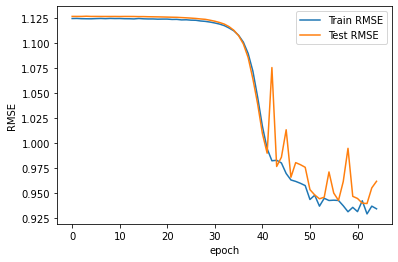

In [22]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

- 모델 Prediction

In [23]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
user_occ = test_occ[0:6]
predictions = model.predict([user_ids, movie_ids, user_occ]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

Actuals: 
        user_id  movie_id  rating
28750      250       270       4
65311      891       280       3
4190       235       898       3
93530      561       144       3
14071      130       800       4
65945      487       156       4

Predictions: 
 [[4.11919  ]
 [3.9827926]
 [3.5645626]
 [3.5674634]
 [3.6975658]
 [4.364308 ]]


- 정확도(RMSE)를 계산하는 함수 

In [24]:
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids, test_occ]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

0.963034593792308